In [1]:
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
img = plt.imread("./dataset/data-uji/Aula_Timur-sore-13317011-001.jpg")
img.shape

(2448, 3264, 3)

In [4]:
cv2.resize(img,(500,500))

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 59,  54,  57],
        [ 63,  59,  60],
        [ 70,  63,  59]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 62,  56,  58],
        [ 66,  61,  63],
        [ 68,  60,  57]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 64,  57,  61],
        [ 78,  75,  76],
        [ 72,  68,  69]],

       ...,

       [[ 73,  71,  74],
        [ 72,  71,  73],
        [ 65,  63,  66],
        ...,
        [103, 104, 107],
        [ 87,  85,  88],
        [ 87,  85,  88]],

       [[ 73,  73,  75],
        [ 70,  68,  71],
        [ 75,  74,  76],
        ...,
        [ 97,  97,  99],
        [102,  97, 102],
        [100,  96, 100]],

       [[ 68,  66,  69],
        [ 74,  74,  76],
        [ 74,  72,  75],
        ...,
        [ 91,  96, 100],
        [104, 100, 105],
        [ 94,  92,  95]]

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [6]:
re = cv2.HuMoments(cv2.moments(gray)).flatten()

In [4]:
import mahotas
haralick = mahotas.features.haralick(gray).mean(axis=0)
haralick

array([ 4.39183821e-02,  1.70913586e+02,  9.87730754e-01,  6.96513622e+03,
        4.28955708e-01,  2.59902165e+02,  2.76896313e+04,  7.38308500e+00,
        1.03391232e+01,  5.77693969e-04,  3.65175031e+00, -4.22564769e-01,
        9.97939349e-01])

----

In [3]:
from imutils import paths
PATH3 = os.path.sep.join(["data-latih/"])
# df = load_dataset(PATH3)

In [2]:
def load_dataset(datasetPath):
    # grab the paths to all images in our dataset directory, then
    # initialize our lists of images
    imagePaths = list(paths.list_images(datasetPath))

    data = []
 
    # loop over the image paths
    for imagePath in imagePaths:
        # load the image and resize it to be a fixed 128x128 pixels,
        # ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (500, 500))
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image.flatten()
        # add the image to the data lists
        data.append(image)
 
    # return the data list as a NumPy array
    return np.array(data, dtype="float32")

In [4]:
df = load_dataset(PATH3)

In [5]:
df

array([[235., 234., 238., ..., 155., 187., 230.],
       [254., 254., 254., ...,  90.,  88.,  88.],
       [237., 231., 232., ..., 111., 107., 118.],
       ...,
       [254., 254., 254., ...,  65., 104., 119.],
       [251., 253., 247., ..., 178., 165., 163.],
       [245., 241., 246., ...,  60., 165., 168.]], dtype=float32)

In [ ]:
import pandas as pd
df_train = pd.DataFrame.from_records(df)
df_train

In [26]:
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [ ]:
y_train = np.ones(df_train.shape[0])
y_train

In [50]:
df.shape

(223, 250000)

In [ ]:
clf = RandomForestClassifier()

clf.fit(df,y_train)

In [69]:
clf.predict(cv2.resize(gray, (500, 500)).flatten().reshape(1, -1))

array([1.])

In [55]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

NameError: name 'y_test' is not defined

In [98]:
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import mahotas
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
fixed_size = (500,500)
bins = 8
test_size = 0.10
seed      = 9
train_path = "dataset/data-latih"
test_path  = "dataset/data-uji"
h5_data    = 'output/data.h5'
h5_labels  = 'output/labels.h5'
scoring    = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)
# print(trainLabelsGlobal)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

# # 10-fold cross validation
# for name, model in models:
#     kfold = KFold(n_splits=10, random_state=seed)
#     cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#     print(msg)

# # boxplot algorithm comparison
# fig = pyplot.figure()
# fig.suptitle('Machine Learning algorithm comparison')
# ax = fig.add_subplot(111)
# pyplot.boxplot(results)
# ax.set_xticklabels(names)
# pyplot.show()

#-----------------------------------
# TESTING OUR MODEL
#-----------------------------------
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

# to visualize results
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler



[STATUS] features shape: (2614, 532)
[STATUS] labels shape: (2614,)
[STATUS] training started...
[STATUS] splitted train and test data...
Train data  : (2352, 532)
Test data   : (262, 532)
Train labels: (2352,)
Test labels : (262,)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)

1


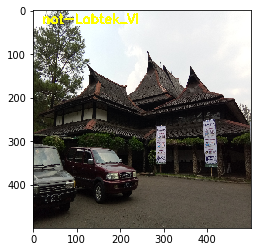

1


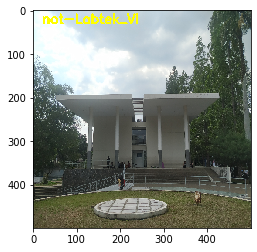

1


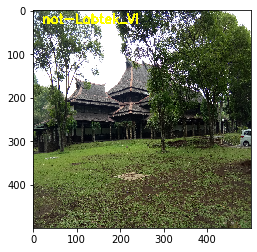

1


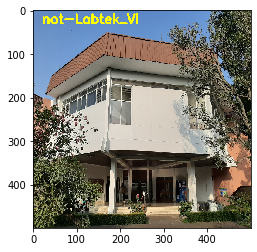

1


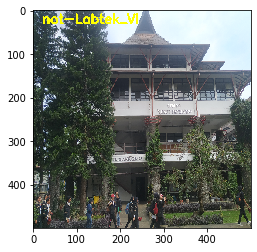

1


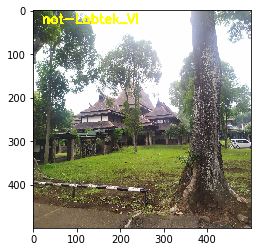

1


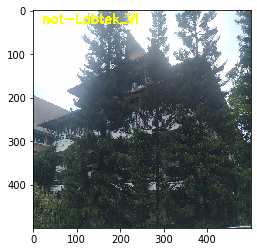

1


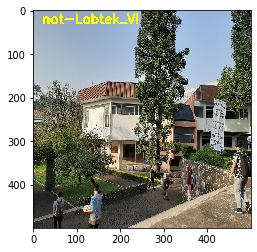

1


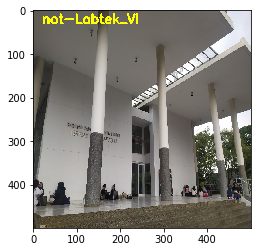

1


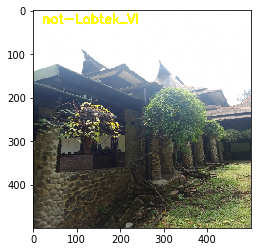

1


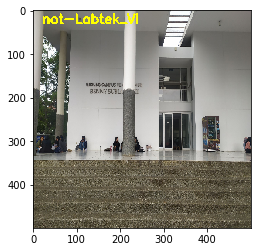

1


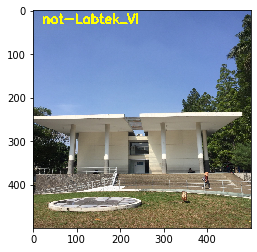

0


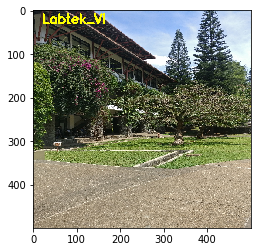

1


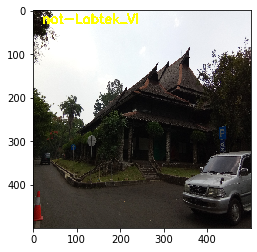

0


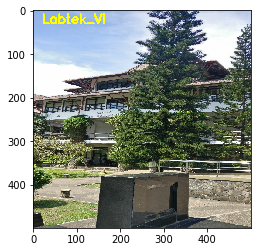

1


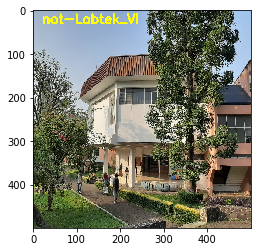

1


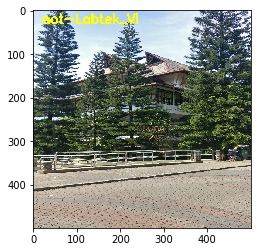

1


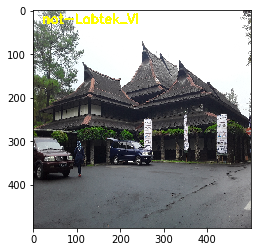

1


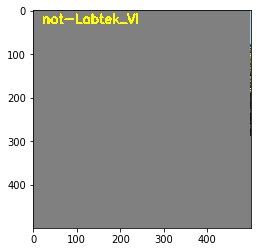

1


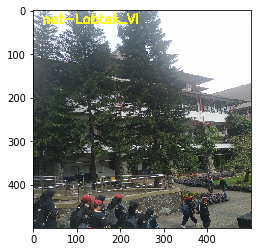

0


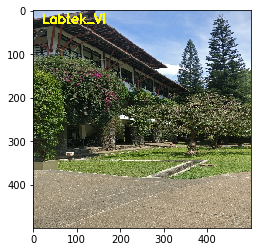

1


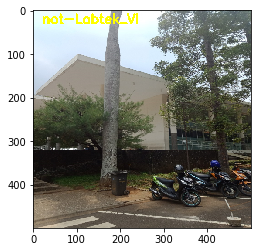

1


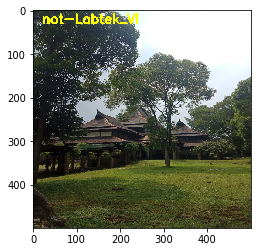

1


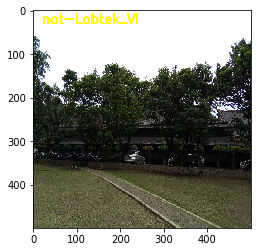

1


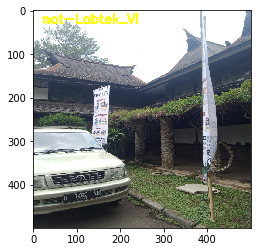

1


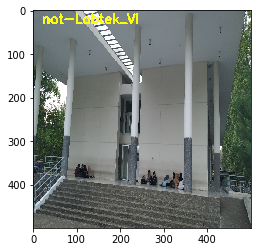

1


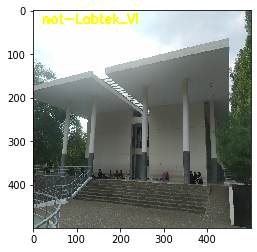

1


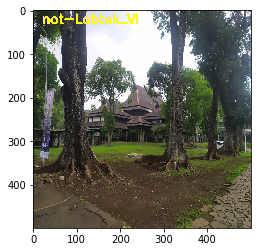

0


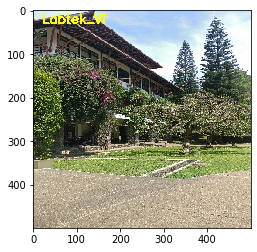

1


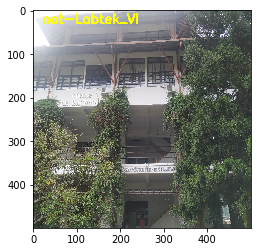

0


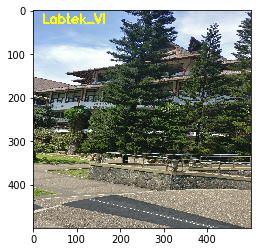

1


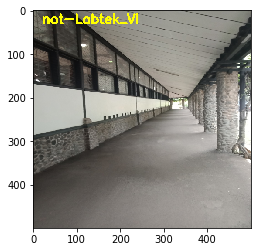

In [101]:
# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# loop through the test images
for file in glob.glob(test_path + "/*.jpg"):
    # read the image
    image = cv2.imread(file)

    # resize the image
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    # print(np.array(global_feature).shape)
    
#     # scale features in the range (0-1)
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     rescaled_feature = scaler.fit_transform(global_feature.reshape(1,-1))

    # predict label of test image
    prediction = clf.predict(global_feature.reshape(1,-1))[0]
    print(prediction)
    
    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()


In [94]:
global_features.shape

(2614, 532)

In [91]:
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_feature.reshape(1,-1))

rescaled_features

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [86]:
global_features[1,:]

array([1.56112034e-03, 1.84599346e-01, 1.58833407e-01, 1.21184330e-01,
       4.09498680e-02, 3.76020199e-02, 3.78258010e-02, 7.76484176e-01,
       2.22841785e-03, 2.04405915e-01, 1.91969396e-01, 1.38555592e-01,
       3.82888863e-02, 1.05487855e-02, 3.76078228e-03, 2.99229203e-03,
       1.05222209e-03, 2.50022674e-02, 2.80468305e-02, 1.14337353e-02,
       9.49211610e-03, 2.54449852e-03, 1.50922954e-03, 1.22457495e-03,
       7.39749679e-04, 4.85161313e-03, 3.54966630e-03, 7.71329026e-03,
       1.91804978e-03, 1.04528491e-03, 1.74808745e-03, 5.54468118e-04,
       2.61306854e-04, 9.72843249e-04, 8.62973939e-04, 6.82343035e-03,
       7.84351353e-03, 1.29431040e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.62696690e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.63866195e-05, 1.59074407e-04, 0.00000000e+00,
       0.00000000e+00, 3.39614801e-04, 0.00000000e+00, 1.16700510e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [79]:

a = clf.predict(rescaled_features)
a

array([0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0])

In [52]:
global_features[1,:].shape

(532,)

In [24]:
clf.predict(global_features[1,:].reshape(1, -1))

array([0])

In [45]:
max(scaler.fit_transform(global_feature.reshape(-1,1))[0])

1.4266709992900345e-05